In [1]:
#import dependencies
import requests
import tweepy
from config import consumer_key, consumer_secret, access_token, access_token_secret
import json
from config1 import key
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
import seaborn as sns
import time

In [2]:
# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

Average overall sentiment is 0.10505599999999998
Sentiment of top 10 influential people is 0.04753
Sentiment of top 10 retweeted tweets is 0.14904
General public has more positive sentiments than top 10 influential people about spacex


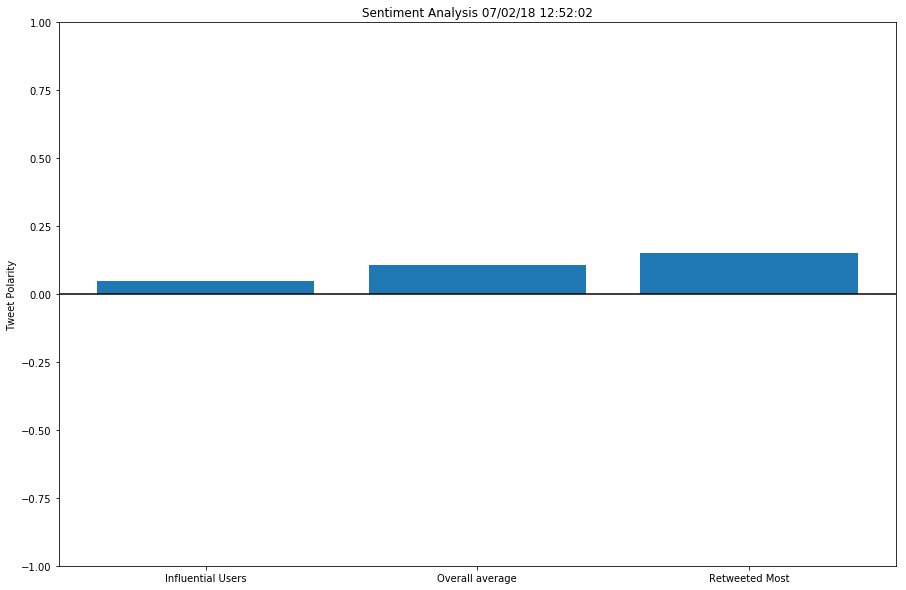

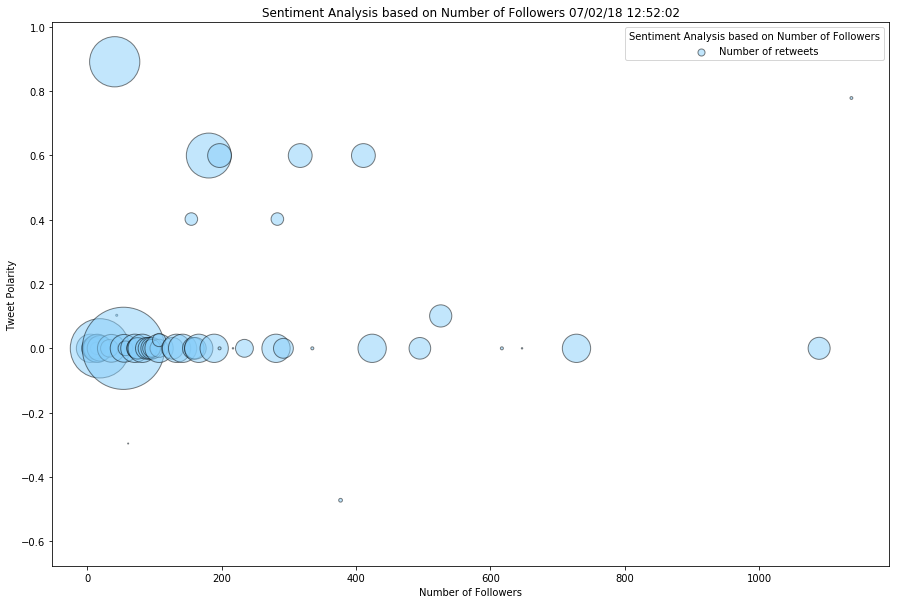

In [3]:
def getSentiments(target_term):
    # Get 100 recent tweets and create lists of tweets, sentiments, followers and retweets
    public_tweets = api.search(target_term, count=100, lang="en", result_type="recent")
    tweets = []
    sentiments = []
    followers = []
    retweets = []
    for tweet in public_tweets['statuses']:
        tweets.append(tweet['text'])
        followers.append(tweet['user']['followers_count'])
        retweets.append(tweet['retweet_count'])
        result = analyzer.polarity_scores(tweet["text"])
        sentiments.append(result['compound'])
    # Create a dataframe by combining all the lists    
    combined_df = pd.DataFrame({'Followers':followers,'Sentiments':sentiments, 'Retweets':retweets, 'Tweets':tweets})
    
    # Calculate average sentiment of top 10 users with most followers
    top_10_followers = combined_df.nlargest(10, 'Followers')
    top_10_followers_average = top_10_followers['Sentiments'].mean()

    top_10_retweets = combined_df.nlargest(10, 'Retweets')
    top_10_retweets_average = top_10_retweets['Sentiments'].mean()

    overal_average = combined_df['Sentiments'].mean()
    
    # Print analysis
    print('Average overall sentiment is ' + str(overal_average))
    print('Sentiment of top 10 influential people is '+str(top_10_followers_average))
    print('Sentiment of top 10 retweeted tweets is '+str(top_10_retweets_average))

    if top_10_followers_average>overal_average:
        print('Top 10 influential people have more positive sentiments than general public about '+target_term)
    else:
        print('General public has more positive sentiments than top 10 influential people about '+target_term)
    
    #Draw bar chart for sentiments
    plt.figure(figsize= (15,10))    
    titles = ['Influential Users','Retweeted Most','Overall average']
    sent = [top_10_followers_average, top_10_retweets_average, overal_average]
    plt.bar(titles, sent)

    plt.title(f"Sentiment Analysis {time.strftime('%x %X')}")
    plt.ylabel("Tweet Polarity")
    plt.axhline(0, color = 'black')
    plt.savefig("output_9_1.png")
    plt.ylim (-1.0,1.0)
    plt.show()
    
    # Draw scatter chart for sentiments, number of followers and number of retweets    
    # Remove users with top 20 follower count to allow more meaningful visualization
    combined_df1 = combined_df.nsmallest(80, 'Followers')
    plt.figure(figsize= (15,10))
    plt.scatter(combined_df1['Followers'], combined_df1['Sentiments'], color="lightskyblue", edgecolor="black"
                , label="Number of retweets", alpha=0.5, s=combined_df1['Retweets'], linewidths=1)
    plt.title(f"Sentiment Analysis based on Number of Followers {time.strftime('%x %X')}")
    plt.xlabel("Number of Followers")
    plt.ylabel("Tweet Polarity")
    #plt.ylim (-1.0,1.0)

    lgnd=plt.legend(loc="upper right", title="Sentiment Analysis based on Number of Followers", scatterpoints=1)
    lgnd.legendHandles[0]._sizes = [50]
    lgnd.legendHandles[0]._sizes = [50]
    lgnd.legendHandles[0]._sizes = [50]
    plt.savefig("output_8_1.png")
    plt.show()
    
    

getSentiments('spacex')

In [4]:
def news_api_data(user_input):
    '''takes an argument "user_input" as keywords to perform API calls to newsapi.org,
    returns a DataFrame with news data
    ''' 
   
    #in case we have several words as user's input, we can mark words or phrases that must appear with a + symbol
    user_input_list=user_input.split(" ")
    user_input_plus="".join(f'+{k}' for k in user_input_list)
    print(user_input_plus)

    url="https://newsapi.org/v2/everything"
    
    #specify parameters for sample, i.e results come from the particular news  resources
    sparams={
       'apiKey': key,
       'q': user_input_plus,
       'language': 'en',
       'pageSize': 100,
       'from': '2017-06-01',
       'sortBy': 'publishedAt',
       'sources': 'abc-news, associated-press, bbc-news, breitbart-news, cbc-news, cbs-news, cnn,  fox-news, daily-mail, independent, nbc-news, newsweek, new-york-magazine, reuters, time, the-globe-and-mail, the-telegraph, the-washington-times, usa-today'
    }
       
    #make API request and retrieve totalResults value 
    responses=requests.get(url, params=sparams)
    
    st_code=responses.status_code   
    if st_code!=200: 
        print(f'API problem, code {responses.status_code}')
    
    news_info=responses.json()
    sample_total=news_info['totalResults']
    
    #if response containes more than 10000 articles, retrive information for 10000.
    #Otherwise API returns an error 419 - too many requests 
    if sample_total>10000:
        sample_total=10000
    print(f'The total number of results is {sample_total}')
   
    #calculate the nuber of pages to iterate through (numer of all results is diveded by 100 (i.e. records per page))
    x=math.ceil(sample_total/100)
    print(f'The number of pages is {x}')
    
    #create DataFrame for retrieved results
    news_data=pd.DataFrame(columns=["published_at","name", "author", "description", "url","year_month"])
    index=0

    #iterate through each page and store  results in the DataFrame
    for page in range(1,x+1):
        sparams['page']=page
        responses=requests.get(url, params=sparams)    
        news_info=responses.json()
        print(f'processing page {page} of {x}')
        if 'articles' not in news_info:
            print(f'skipping page {page} of {x}')
            continue
        for article in news_info['articles']:
            news_data.loc[index,"published_at"]=article["publishedAt"]
            news_data.loc[index,"name"]=article["source"]["name"]
            news_data.loc[index,"author"]=article["author"]
            news_data.loc[index,"description"]=article["description"]
            news_data.loc[index,"url"]=article["url"]
            news_data.loc[index,"year_month"]=article["publishedAt"][:7]
            index+=1
    
    #clean the data from duplicate records 
    news_data.drop_duplicates(subset=['published_at','name','description'], keep='first', inplace=True)
    news_data.head(20)
    news_data.to_csv("report.csv")
    news_data.info()
    return news_data              

In [5]:
news_dat=news_api_data('spacex')
news_dat.head(10)

+spacex
The total number of results is 1986
The number of pages is 20
processing page 1 of 20
processing page 2 of 20
processing page 3 of 20
processing page 4 of 20
processing page 5 of 20
processing page 6 of 20
processing page 7 of 20
processing page 8 of 20
processing page 9 of 20
processing page 10 of 20
processing page 11 of 20
processing page 12 of 20
processing page 13 of 20
processing page 14 of 20
processing page 15 of 20
processing page 16 of 20
processing page 17 of 20
processing page 18 of 20
processing page 19 of 20
processing page 20 of 20
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1974 entries, 0 to 1985
Data columns (total 6 columns):
published_at    1974 non-null object
name            1974 non-null object
author          1903 non-null object
description     1970 non-null object
url             1974 non-null object
year_month      1974 non-null object
dtypes: object(6)
memory usage: 108.0+ KB


,published_at,name,author,description,url,year_month
0,2018-07-02T15:54:29Z,Associated Press,By WAYNE PARRY Associated Press,"LACEY TOWNSHIP, N.J. (AP) — Federal regulators...",https://apnews.com/8710cbcd59c142779217a967dd2...,2018-07
1,2018-07-02T15:33:58Z,Daily Mail,http://www.dailymail.co.uk/home/search.html?s=...,SpaceX's capsule reached the station three day...,http://www.dailymail.co.uk/sciencetech/article...,2018-07
2,2018-07-02T14:09:20Z,CBS News,William Harwood,A SpaceX Dragon cargo ship was attached to the...,https://www.cbsnews.com/news/spacex-dragon-car...,2018-07
3,2018-07-02T13:23:26Z,USA Today,"AP, AP, AP",A SpaceX capsule arrived at the International ...,https://www.usatoday.com/videos/news/nation/20...,2018-07
4,2018-07-02T13:18:43Z,CBC News,The Associated Press,A SpaceX capsule has arrived at the Internatio...,https://www.cbc.ca/news/technology/spacex-drag...,2018-07
5,2018-07-02T12:50:02Z,Reuters,Jeremy Schultz,A SpaceX Falcon 9 rocket exits the atmosphere ...,https://www.reuters.com/news/picture/editors-c...,2018-07
6,2018-07-02T12:39:59Z,Daily Mail,http://www.dailymail.co.uk/home/search.html?s=...,The capsule reached the International Space St...,http://www.dailymail.co.uk/wires/pa/article-59...,2018-07
7,2018-07-02T12:00:12Z,Reuters,Thomson Reuters,A robot named CIMON arrived at the Internation...,https://www.reuters.com/video/2018/07/02/ai-ro...,2018-07
8,2018-07-02T11:03:03Z,Daily Mail,http://www.dailymail.co.uk/home/search.html?s=...,"CAPE CANAVERAL, Fla. (AP) - A SpaceX shipment ...",http://www.dailymail.co.uk/wires/ap/article-59...,2018-07
9,2018-07-02T10:56:44Z,Associated Press,By MARCIA DUNN AP Aerospace Writer,"CAPE CANAVERAL, Fla. (AP) — A SpaceX shipment ...",https://apnews.com/6098517f2ff949d3a65ebd80e51...,2018-07


In [6]:
def bar_news(news_data):
    '''takes a DataFrame as an argument, 
    creates a bar chart "Overal Quantity of Articles per News Source"
    ''' 
    #group data by News Sources names
    group_news=news_data.groupby("name")
    group_count=group_news['published_at'].count().rename("count")

    df_group_count=pd.DataFrame(group_count)
    df_group_count.sort_values(by=['count'], inplace=True, ascending=False)
    df_group_count.reset_index(inplace=True)
    
    #create a bar chart to show quantity of articles for each news source 
    group_name=df_group_count['name']
    y_pos=np.arange(len(df_group_count['count']))
    plt.figure(figsize=(10, 7))
    plt.barh(y_pos, df_group_count['count'], tick_label=group_name, alpha=0.6, color="green")
    plt.title(f"Overal Quantity of Articles per News Source 09/01/17-{time.strftime('%x')}")
    plt.xlabel("Number of Articles")
    plt.savefig("news_bar_chart.png", dpi=100, bbox_inches='tight')
    plt.show()
    
    #add analysis for bar chart
    q=len(df_group_count['count'])-1
    name_min=df_group_count.iloc[q,0]
    min_q=df_group_count.iloc[q,1]
    
    name_max=df_group_count.iloc[0,0]
    max_q=df_group_count.iloc[0,1]
    print(f'Based on the analysis of "Overal Quantity of Articles per News Source" chart, we can notice that {name_max} published the maximum number of articles ({max_q}).' ) 
    print(f'{name_min} published the minimal quantity of articles ({min_q}) related to the given keywords.')

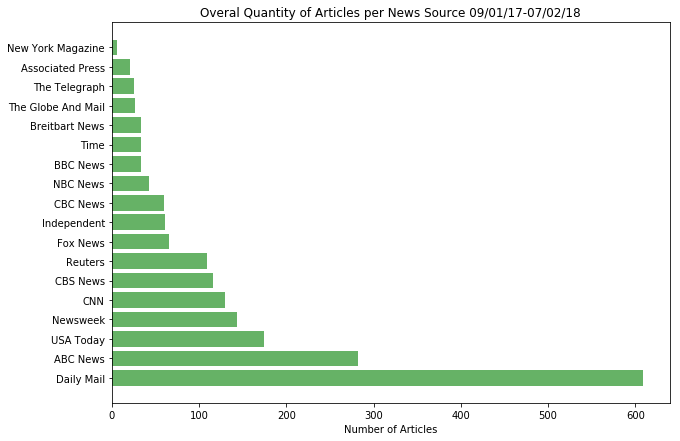

Based on the analysis of "Overal Quantity of Articles per News Source" chart, we can notice that Daily Mail published the maximum number of articles (609).
New York Magazine published the minimal quantity of articles (6) related to the given keywords.


In [7]:
bar_news(news_dat)

In [8]:
def compound_score_data(news_data):
    '''takes a DataFrame as an argument and calculates compound scores for articles description,
    returns a new DataFrame
    '''
    news_data_new=news_data.loc[:,['year_month', 'name', 'description']]
    for index, row in news_data_new.iterrows():
        text=news_data_new.loc[index,"description"]
        if text:
            results = analyzer.polarity_scores(text)
            news_data_new.loc[index,"score"]=round(results["compound"],2)
        else:
            news_data_new.drop(index, inplace=True)
    return(news_data_new)

In [9]:
compound_df=compound_score_data(news_dat)
compound_df.head(10)

,year_month,name,description,score
0,2018-07,Associated Press,"LACEY TOWNSHIP, N.J. (AP) — Federal regulators...",0.00
1,2018-07,Daily Mail,SpaceX's capsule reached the station three day...,0.10
2,2018-07,CBS News,A SpaceX Dragon cargo ship was attached to the...,0.00
3,2018-07,USA Today,A SpaceX capsule arrived at the International ...,0.48
4,2018-07,CBC News,A SpaceX capsule has arrived at the Internatio...,0.00
5,2018-07,Reuters,A SpaceX Falcon 9 rocket exits the atmosphere ...,0.00
6,2018-07,Daily Mail,The capsule reached the International Space St...,0.10
7,2018-07,Reuters,A robot named CIMON arrived at the Internation...,-0.27
8,2018-07,Daily Mail,"CAPE CANAVERAL, Fla. (AP) - A SpaceX shipment ...",0.00
9,2018-07,Associated Press,"CAPE CANAVERAL, Fla. (AP) — A SpaceX shipment ...",0.48


In [10]:
def compound_scores_heat_map(news_data_new):
    '''takes a DataFrame with compound scores as an argument,
    creates a heatmap chart for average compound scores.
    Since some news sources didn't publish articles on particular months,
    using pd.pivot_table gives us a 2D Series where missing values are replaced with NaN.
    '''
    c_matrix = pd.pivot_table(news_data_new, "score", index=["name"], columns=["year_month"], aggfunc=np.mean)                          
    c_matrix=c_matrix.round(2)
    
    #create a heatmap chart of the average compound scores
    fig = plt.figure(figsize=(12,12))
    hm = sns.heatmap(c_matrix, cmap='RdYlGn', annot=True)
    hm.set_title(f"Heatmap of Avg. Compound Scores 09/01/17-{time.strftime('%x')}")
    plt.savefig("compound_scores_heat_map.png", dpi=100)
    plt.show()

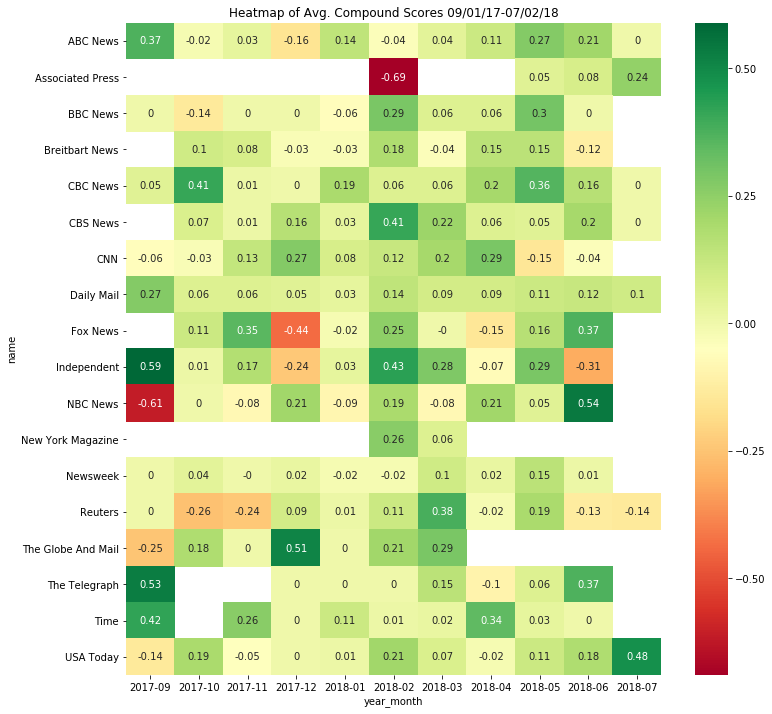

In [11]:
compound_scores_heat_map(compound_df)

In [12]:
def count_articles_heat_map(news_data): 
    '''takes a DataFrame as an argument,
    creates a heatmap chart "Number of Articles per Month"
    Since some news sources didn't publish articles on particular months,
    using pd.pivot_table gives us a 2D Series where missing values are replaced with NaN.
    '''
    d_matrix = pd.pivot_table(news_data, "url", index=["name"], columns=["year_month"], aggfunc='count')                          
    d_matrix.head(20)
    fig = plt.figure(figsize=(12,12))
    cm = sns.heatmap(d_matrix, cmap='YlGnBu', annot=True, fmt='g')
    cm.set_title(f"Number of Articles per Month 09/01/17-{time.strftime('%x')}")
    plt.savefig("count_values_heat_map.png", dpi=100)
    plt.show()

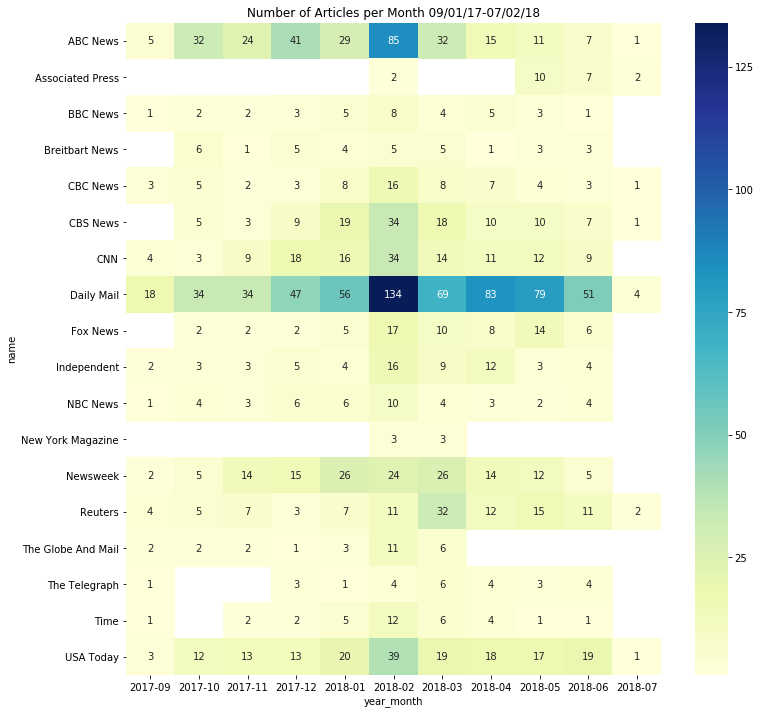

In [13]:
count_articles_heat_map(news_dat)